# Stock Predictor
LSTM architecture to predict Stockprices based on [this Kaggle Dataset](https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs)


In [1]:
%matplotlib inline
from IPython.display import display, clear_output
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
import matplotlib
import time
matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
torch.manual_seed(1)

False


In [22]:
csv = pd.read_csv('./googl.us.txt')
csv.drop(columns=["OpenInt", "Date"], inplace=True)
data = torch.tensor(csv.values, dtype=torch.float)
data = data[:-3]
print(data.size()[0])

3330


In [23]:
for column in range(5):
    data[:, column] /= torch.max(data[:, column])
    data[:, column] -= data[:, column].mean()

In [90]:
class StockPredictor(nn.Module):
    def __init__(self, structure):
        super(StockPredictor, self).__init__()
        self.structure = structure
        self.layers = len(structure)
        self.lstms = [nn.LSTM(i, o) for i, o in zip(structure[:-2], structure[1:-1])]
        self.final = nn.Linear(structure[-2], structure[-1])
        self.activation = nn.LeakyReLU()
    def forward(self, stock, keep_hidden_state=False, batches=10):
        if not keep_hidden_state:
            self.init_hidden(batches)
        for i, lstm in enumerate(self.lstms):
            if i != 0:
                out, self.hidden[i] = lstm(out, self.hidden[i])
            else:
                out, self.hidden[i] = lstm(stock, self.hidden[i])
            #out = self.activation(out)
        out = self.final(out)
        return out
    def sample(self, length):
        initial_input = torch.randn(1, 1, 5)
        sample =[]
        out = self.forward(initial_input, batches=1)
        sample.append(out.tolist())
        for i in range(1, length):
            out = self.forward(out, batches=1, keep_hidden_state=True)
            sample.append(out.tolist())
        return torch.tensor(sample)
    def init_hidden(self, batches):
        self.hidden = [(torch.zeros(1, batches, layer_size),
                       torch.zeros(1, batches, layer_size))for layer_size in self.structure[1:]] 
        

In [107]:
model = StockPredictor((5, 10, 5))
optim = torch.optim.RMSprop(model.parameters(), lr=0.001)


In [82]:
#load ignore if you want a new model
model.load_state_dict(torch.load("./model.sav"))
model.eval()

StockPredictor(
  (final): Linear(in_features=10, out_features=5, bias=True)
  (activation): LeakyReLU(negative_slope=0.01)
)

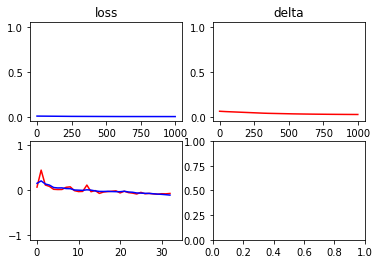

999: 0.024750223383307457 | 0.0014529651962220669


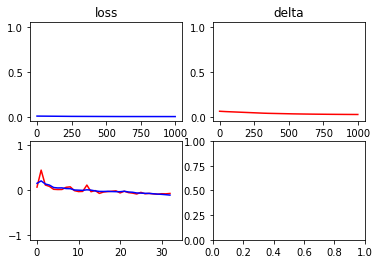

In [117]:
test_seperate = 3000
epochs = 1000
batches = 100
target_offset = 1
losses = []
deltas = []
fig, ((lax, dax), (cmpax, _)) = plt.subplots(ncols=2, nrows=2)
lplot, = lax.plot([0, epochs], [1, 0], 'b')
lax.set_title("loss")
dplot, = dax.plot([0, epochs], [1, 0], 'r')
dax.set_title("delta")
rplot, = cmpax.plot([0, (data.size()[0]-target_offset)/batches], [-1, 1], 'r')
pplot, = cmpax.plot([0, (data.size()[0]-target_offset)/batches], [-1, 1], 'b')
cutoff = (data.size()[0] - target_offset) % batches
print(cutoff)
if cutoff != 0:
    prep_data = data[:-cutoff]
else:
    prep_data = data
batch_len = int(prep_data.size()[0]/batches)
inputs = prep_data[:-target_offset, :].view(-1, batches, 5) #inferring length of the sequence
target = prep_data[target_offset:, :].view(-1, batches, 5)
for epoch in range(epochs):
    model.zero_grad()
    prediction = model.forward(inputs, batches=batches)
    loss = ((prediction - target)**2).mean()
    loss.backward()
    optim.step()
    delta = (prediction - target).abs().mean()
    # visualising learning progress
    deltas.append(np.asscalar(delta.detach().numpy()))
    losses.append(np.asscalar(loss.detach().numpy()))
    lplot.set_data(range(epoch+1), losses)
    dplot.set_data(range(epoch+1), deltas)
    rplot.set_data(range(target.size()[0]), target[:, epoch % batches, int((epoch/10) % 5)].detach().numpy())
    pplot.set_data(range(target.size()[0]), prediction[:, epoch % batches, int((epoch/10) % 5)].detach().numpy())
    clear_output(wait=True)
    display(fig)
    print(f'\r{epoch}: {delta} | {loss.detach()}')
    
plt.show()    
    

In [78]:
#saving
torch.save(model.state_dict(), "./model.sav")
state = model.state_dict()

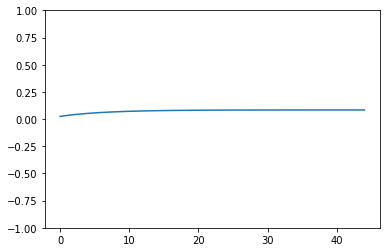

In [116]:
#model.load_state_dict(state)
sample = model.sample(50)
plt.ylim(-1, 1)
plt.plot(sample.numpy()[5:, 0, 0, 1])
plt.show()